In [2]:
import os
import time
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
data = pd.read_csv('selected_data.csv')
data['GDatetime'] = pd.to_datetime(data['GDatetime'])
data.set_index('GDatetime', inplace=True)
data

,F_RunState,F_CycleTime,F_SpindleRPM1,F_SpindleTroq1,F_SpindleGearRatio1,F_ToolNum,G_ADC1,G_ADC2,G_ADC3,G_MV,G_MA,G_MActP,G_MFeq,G_MTemp,label,anomaly
GDatetime,,,,,,,,,,,,,,,,
2023-06-05 07:03:45,2.0,0.0,0.0,0.0,0.0,0.0,24.400000,43.700001,0.0,222.020004,2.974,0.924,59.970001,39.0,0,0
2023-06-05 07:03:46,2.0,0.0,0.0,0.0,0.0,0.0,24.400000,43.700001,0.0,221.529999,2.976,0.924,59.970001,39.0,0,0
2023-06-05 07:03:47,2.0,0.0,0.0,0.0,0.0,0.0,24.400000,43.700001,0.0,221.529999,2.976,0.924,59.970001,39.0,0,0
2023-06-05 07:03:48,2.0,0.0,0.0,0.0,0.0,0.0,24.400000,43.700001,0.0,220.729996,2.976,0.920,59.959999,39.0,0,0
2023-06-05 07:03:49,2.0,0.0,0.0,0.0,0.0,0.0,24.299999,43.700001,0.0,221.630005,2.962,0.920,59.959999,39.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01 16:27:16,2.0,10424.0,0.0,0.0,712.0,21.0,37.200001,38.900002,0.0,220.570007,11.092,2.656,59.970001,45.0,363,0
2023-07-01 16:27:17,2.0,10424.0,0.0,0.0,712.0,21.0,37.200001,38.900002,0.0,220.669998,11.046,2.644,59.970001,45.0,363,0
2023-07-01 16:27:18,2.0,10424.0,0.0,0.0,712.0,21.0,37.200001,38.900002,0.0,220.669998,11.046,2.644,59.970001,45.0,363,0


In [6]:
def find_cycle_periods(data, threshold_low=100, threshold_high=10000, sub_cycle_threshold=1000, sub_cycle_length_minutes=50):
    cycle_starts = []
    cycle_ends = []
    in_cycle = False
    in_high = False
    in_sub_cycle = False
    label = -1 # 주기 라벨 (0부터 시작)
    
    # label 열을 추가하고 -1로 초기화
    data['label'] = 0
    sub_cycle_start_time = None
    sub_cycle_length = 0
    
    for i in range(len(data) - 1):
        value = data['F_CycleTime'].iloc[i]
        next_value = data['F_CycleTime'].iloc[i + 1]
        
        # 주기 시작 지점 찾기 (0 ~ 100 근처에서 올라가기 시작)
        if not in_cycle and value <= threshold_low:
            in_cycle = True
            label += 1 # 새로운 주기 시작, 라벨 증가
            cycle_starts.append(data.index[i]) # datetime 인덱스 사용
        
        # 주기 내부라면 현재 라벨로 표시
        if in_cycle:
            data['label'].iloc[i] = label

        # 1만 근처의 값에 도달
        if in_cycle and not in_high and value >= threshold_high:
            in_high = True

        # 1천 근처의 값에 도달
        if in_cycle and not in_high and value >= sub_cycle_threshold:
            in_sub_cycle = True
            if sub_cycle_start_time is None:
                sub_cycle_start_time = data.index[i]

        # 하위 주기의 끝 지점 찾기
        if in_sub_cycle and next_value <= threshold_low:
            sub_cycle_length += (data.index[i] - sub_cycle_start_time).seconds / 60
            sub_cycle_start_time = None
            if sub_cycle_length >= sub_cycle_length_minutes:
                in_high = True
            in_sub_cycle = False
            
        # 주기 끝 지점 찾기
        if in_high and next_value <= threshold_low:
            in_high = False
            in_cycle = False
            cycle_ends.append(data.index[i]) # datetime 인덱스 사용
            sub_cycle_length = 0
            
    # 마지막 주기의 끝 지점 처리
    if in_cycle:
        cycle_ends.append(data.index[-1])

    return cycle_starts, cycle_ends


def remove_constant_values(data, lower_bound=1000, upper_bound=12000, duration_minutes=20):
    constant_value = None
    constant_start_time = None
    rows_to_drop = []

    for i in range(len(data) - 1):
        value = data['F_CycleTime'].iloc[i]

        # 값이 범위 내에 있고 이전 값과 동일한 경우
        if lower_bound <= value < upper_bound and value == constant_value:
            if constant_start_time is None:
                constant_start_time = data.index[i]
            # 지속 시간이 20분 이상인 경우
            if (data.index[i] - constant_start_time).seconds / 60 >= duration_minutes:
                rows_to_drop.append(data.index[i])
        else:
            constant_value = value
            constant_start_time = None

    # 행 삭제
    data.drop(rows_to_drop, inplace=True)
    return data



selected_data = data

selected_data = remove_constant_values(selected_data)

# 중복된 인덱스를 가진 행의 평균값으로 병합
selected_data = selected_data.groupby(selected_data.index).mean()

cycle_starts, cycle_ends = find_cycle_periods(selected_data)

selected_data = selected_data.iloc[:-1]
selected_data['anomaly'] = 0
specific_labels = [43, 188, 243, 256, 258, 270, 291, 295, 325, 340, 349, 360]
selected_data.loc[selected_data['label'].isin(specific_labels), 'anomaly'] = 1

In [27]:
# 특징 선별
selected_k = selected_data.drop(['G_ADC1', 'G_ADC2', 'G_MV', 'G_MA', 'G_MActP', 'G_MFeq', 'G_MTemp'], axis=1)

In [127]:
# 통계 데이터 생성 및 결합
tmp1 = selected_k.groupby('label').mean()
tmp2 = selected_k.groupby('label').std().drop('anomaly', axis=1)
tmp3 = selected_k.groupby('label').skew().drop('anomaly', axis=1)

tmp1 = tmp1.add_suffix('_mean')
tmp2 = tmp2.add_suffix('_std')
tmp3 = tmp3.add_suffix('_skew')

# 데이터프레임 연결
tmp = pd.concat([tmp1, tmp2, tmp3], axis=1)

In [128]:
kktr = [0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196,
       197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,
       210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,
       223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,
       236, 237, 238, 239, 240, 241, 242, 244, 245, 246, 247, 248, 249,
       250, 251, 252, 253, 254, 255, 257, 259, 260, 261, 262, 263, 264,
       265, 266, 267, 268, 269, 271, 272, 273, 274, 275, 276, 277, 278,
       279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 292,
       293, 294, 296,43, 188, 243, 256, 258, 270, 291, 295]
kkte = [297, 298, 299, 300, 301, 302, 303, 304, 305, 306,
       307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
       320, 321, 322, 323, 324, 326, 327, 328, 329, 330, 331, 332, 333,
       334, 335, 336, 337, 338, 339, 341, 342, 343, 344, 345, 346, 347,
       348, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 361, 362,
       363, 325, 340, 349, 360]


k_X_train = tmp[tmp.index.isin(kktr)].drop('anomaly_mean', axis=1)
k_y_train = tmp[tmp.index.isin(kktr)]['anomaly_mean']
k_X_test = tmp[tmp.index.isin(kkte)].drop('anomaly_mean', axis=1)
k_y_test = tmp[tmp.index.isin(kkte)]['anomaly_mean']

In [323]:
k_X_train = pd.concat([pd.DataFrame(mm.fit_transform(k_X_train.iloc[:, :2])), pd.DataFrame(std.fit_transform(k_X_train.iloc[:, 2:]))], axis=1)
k_X_test = pd.concat([pd.DataFrame(mm.fit_transform(k_X_test.iloc[:, :2])), pd.DataFrame(std.fit_transform(k_X_test.iloc[:, 2:]))], axis=1)

In [117]:
tmp_sne = tmp.drop('anomaly_mean', axis=1)

In [119]:
tmp_sne

,F_RunState_mean,F_CycleTime_mean,F_SpindleRPM1_mean,F_SpindleTroq1_mean,F_SpindleGearRatio1_mean,F_ToolNum_mean,G_ADC3_mean,F_RunState_std,F_CycleTime_std,F_SpindleRPM1_std,...,F_SpindleGearRatio1_std,F_ToolNum_std,G_ADC3_std,F_RunState_skew,F_CycleTime_skew,F_SpindleRPM1_skew,F_SpindleTroq1_skew,F_SpindleGearRatio1_skew,F_ToolNum_skew,G_ADC3_skew
label,,,,,,,,,,,,,,,,,,,,,
0,1.833453,2512.398440,1701.147454,3.979204,615.651488,23.987809,0.205002,1.245417,2876.452756,1721.200406,...,194.500908,20.985514,0.614193,1.022793,1.286844,0.958959,6.888482,-2.834007,0.166315,3.709042
1,1.104677,3558.811526,2240.857879,5.550947,679.478842,36.607183,0.303591,0.445480,2634.266984,1834.932834,...,15.756858,15.744644,0.756331,4.021830,1.147935,0.390190,5.986155,0.701661,-0.212162,3.425454
2,1.148263,3665.662649,2219.902022,5.432478,680.252981,36.677553,0.296916,0.524038,2705.414605,1837.611205,...,15.912721,15.542784,0.752859,3.252353,1.135276,0.413929,5.665792,0.718905,-0.213436,3.446268
3,1.435526,4221.322697,1850.495066,4.635307,685.000000,36.802851,0.244737,0.825276,3198.056161,1871.907642,...,18.899673,16.053580,0.661158,1.368123,0.928508,0.648158,6.330559,0.289183,-0.059481,3.366651
4,1.183333,4032.878846,2161.026538,5.622564,680.512821,35.367436,0.311282,0.576961,3029.381671,1839.026906,...,16.531800,15.078188,0.799478,2.831284,0.961808,0.450218,5.867088,0.637849,-0.110628,3.721013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,1.080798,3529.362095,2277.042893,5.588030,678.958603,36.711970,0.311222,0.392567,2518.111578,1825.202552,...,15.006335,15.245479,0.719190,4.670205,1.107426,0.386086,5.572152,0.721584,-0.259192,2.560822
360,1.813826,1613.587001,1688.470350,4.245006,687.174782,35.792915,0.198814,1.201613,1573.492405,1914.788871,...,18.056344,16.451736,0.598201,0.936346,0.733362,0.730714,6.283546,-0.042904,-0.242556,3.474774
361,1.180552,3859.211942,2154.770120,5.369129,680.524900,34.662969,0.309181,0.570538,2909.423214,1847.270980,...,16.237966,15.516484,0.712258,2.860351,1.041314,0.449224,5.952786,0.595427,-0.133391,2.620763


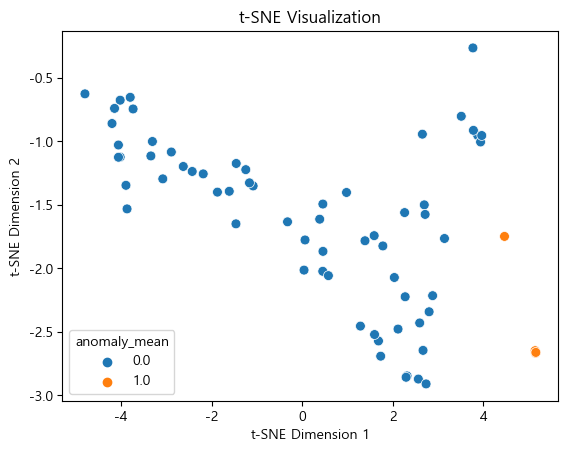

In [137]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNE를 위한 객체 생성
tsne = TSNE(n_components=2, random_state=42)

# t-SNE를 통해 데이터를 2D 공간으로 변환
data_tsne = tsne.fit_transform(k_X_test)  # data는 변환할 데이터입니다.

# 변환된 데이터를 시각화
sns.scatterplot(data=data_tsne, x=data_tsne[:, 0],y=data_tsne[:, 1],hue=k_y_test, legend='brief', s=50, linewidth=0.5)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization')
plt.show()

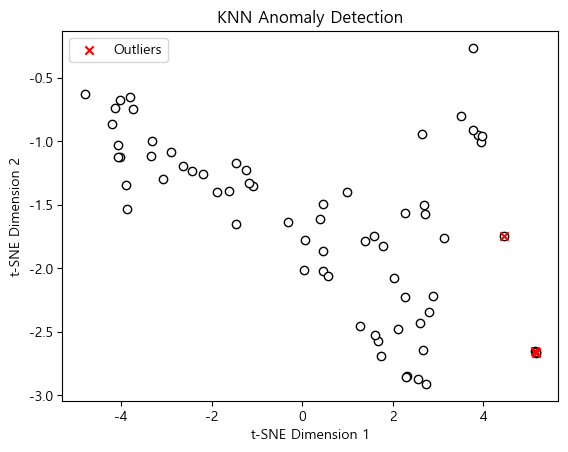

In [142]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# 데이터 준비 (data_tsne 변수는 이전 t-SNE 결과를 활용)
data = data_tsne  # t-SNE로 변환된 데이터 사용

# KNN 모델 생성
k = 5  # 이웃의 수 설정
knn = NearestNeighbors(n_neighbors=k)
knn.fit(data)

# 각 데이터 포인트의 이웃 거리 가져오기
distances, _ = knn.kneighbors()

# 이상치 스코어 계산 (평균 이웃 거리 활용)
outlier_scores = np.mean(distances, axis=1)

# 이상치 여부 판단 (상위 n%만 이상치로 간주)
n_percentile = 95  # 상위 n% 이상치로 간주
threshold = np.percentile(outlier_scores, n_percentile)

# 이상치 인덱스 가져오기
outliers_indices = np.where(outlier_scores > threshold)[0]

# 이상치 시각화
plt.scatter(data[:, 0], data[:, 1], c='white', edgecolors='k')
plt.scatter(data[outliers_indices, 0], data[outliers_indices, 1], c='red', edgecolors='k', marker='x', label='Outliers')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('KNN Anomaly Detection')
plt.legend()
plt.show()

In [143]:
outliers_indices

array([28, 43, 52, 63], dtype=int64)

In [144]:
boolean_values = outlier_scores > threshold

In [145]:
int_values = [int(value) for value in boolean_values]
int_values

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0]

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


# 혼동 행렬 계산 및 출력
confusion = confusion_matrix(k_y_test, int_values)
print("Confusion Matrix:")
print(confusion)

# 분류 보고서 출력
report = classification_report(k_y_test, int_values)
print("Classification Report:")
print(report)

Confusion Matrix:
[[63  0]
 [ 0  4]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        63
         1.0       1.00      1.00      1.00         4

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67



In [111]:
tmp

,F_RunState_mean,F_CycleTime_mean,F_SpindleRPM1_mean,F_SpindleTroq1_mean,F_SpindleGearRatio1_mean,F_ToolNum_mean,G_ADC3_mean,anomaly_mean,F_RunState_std,F_CycleTime_std,...,F_SpindleGearRatio1_std,F_ToolNum_std,G_ADC3_std,F_RunState_skew,F_CycleTime_skew,F_SpindleRPM1_skew,F_SpindleTroq1_skew,F_SpindleGearRatio1_skew,F_ToolNum_skew,G_ADC3_skew
label,,,,,,,,,,,,,,,,,,,,,
0,1.833453,2512.398440,1701.147454,3.979204,615.651488,23.987809,0.205002,0.0,1.245417,2876.452756,...,194.500908,20.985514,0.614193,1.022793,1.286844,0.958959,6.888482,-2.834007,0.166315,3.709042
1,1.104677,3558.811526,2240.857879,5.550947,679.478842,36.607183,0.303591,0.0,0.445480,2634.266984,...,15.756858,15.744644,0.756331,4.021830,1.147935,0.390190,5.986155,0.701661,-0.212162,3.425454
2,1.148263,3665.662649,2219.902022,5.432478,680.252981,36.677553,0.296916,0.0,0.524038,2705.414605,...,15.912721,15.542784,0.752859,3.252353,1.135276,0.413929,5.665792,0.718905,-0.213436,3.446268
3,1.435526,4221.322697,1850.495066,4.635307,685.000000,36.802851,0.244737,0.0,0.825276,3198.056161,...,18.899673,16.053580,0.661158,1.368123,0.928508,0.648158,6.330559,0.289183,-0.059481,3.366651
4,1.183333,4032.878846,2161.026538,5.622564,680.512821,35.367436,0.311282,0.0,0.576961,3029.381671,...,16.531800,15.078188,0.799478,2.831284,0.961808,0.450218,5.867088,0.637849,-0.110628,3.721013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,1.080798,3529.362095,2277.042893,5.588030,678.958603,36.711970,0.311222,0.0,0.392567,2518.111578,...,15.006335,15.245479,0.719190,4.670205,1.107426,0.386086,5.572152,0.721584,-0.259192,2.560822
360,1.813826,1613.587001,1688.470350,4.245006,687.174782,35.792915,0.198814,1.0,1.201613,1573.492405,...,18.056344,16.451736,0.598201,0.936346,0.733362,0.730714,6.283546,-0.042904,-0.242556,3.474774
361,1.180552,3859.211942,2154.770120,5.369129,680.524900,34.662969,0.309181,0.0,0.570538,2909.423214,...,16.237966,15.516484,0.712258,2.860351,1.041314,0.449224,5.952786,0.595427,-0.133391,2.620763
